In [2]:
import math
import pickle
import numpy as np
import pandas as pd
import pickle as pklb
import datetime
from scipy.stats import beta
from tqdm import tqdm
from collections import defaultdict
import pickle as pkl

from transformers import BertTokenizer, BertModel

import os
import ast
#from Content import *
#from Venue import *

import torch

In [3]:
## People
## Time
## Topic
## Media Contents


In [4]:
out_dir = './data/aliceysu'
journalist = 'aliceysu'
with open(os.path.join(out_dir, f'{journalist}_dict.pkl'), 'rb') as f:
    data = pickle.load(f)

with open(os.path.join(out_dir, f'{journalist}_ids.pkl'), 'rb') as f:
    map_id = pickle.load(f)
    
with open(os.path.join(out_dir, f'{journalist}_lan.pkl'), 'rb') as f:
    map_lan = pickle.load(f)

with open(os.path.join(out_dir, f'{journalist}_type.pkl'), 'rb') as f:
    map_type = pickle.load(f)

with open(os.path.join(out_dir, f'{journalist}_reply.pkl'), 'rb') as f:
    map_reply = pickle.load(f)

alice = pd.DataFrame.from_dict(data)
alice_sort = alice.sort_values(by=['created_at'])
conv = pd.read_csv(os.path.join(out_dir, f'{journalist}_conv_labels.csv'))

data = pkl.load(open(os.path.join(out_dir, f'{journalist}_dict.pkl'), 'rb'))
journal = pd.DataFrame.from_dict(data)
journal_sort = pd.read_csv(os.path.join(out_dir, f'{journalist}_context.csv'))

In [54]:
short_gap = []
for item in journal_sort['time gap']:
    if item < 240:
        short_gap.append(item)
        
max_gap = 240
data = []
# for index, item in journal_sort.iterrows():
#     data.append(superbeta.pdf(1-item['time gap'] / max_gap) + 1e-20)
for item in short_gap:
    data.append(superbeta.pdf(1 - item / max_gap) + 1e-10)

(array([9.032e+03, 4.310e+02, 2.050e+02, 1.590e+02, 8.200e+01, 1.000e+02,
        9.100e+01, 8.800e+01, 6.000e+01, 3.700e+01, 3.300e+01, 2.400e+01,
        1.800e+01, 1.600e+01, 1.200e+01, 1.100e+01, 7.000e+00, 6.000e+00,
        4.000e+00, 6.000e+00]),
 array([  0. ,  11.9,  23.8,  35.7,  47.6,  59.5,  71.4,  83.3,  95.2,
        107.1, 119. , 130.9, 142.8, 154.7, 166.6, 178.5, 190.4, 202.3,
        214.2, 226.1, 238. ]),
 <BarContainer object of 20 artists>)

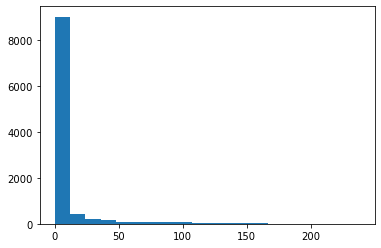

In [55]:
plt.hist(short_gap, bins=20)
plt.scatter(short_gap, data)

In [5]:
ids = list(set(journal_sort['conversation_id']))
batch_data = []
target_data = []
conv_data = []
ref_data = []
id_data = []
for idx in ids:
    convs = journal_sort[journal_sort['conversation_id'] == idx]
    convs_batch = convs[["type", "possibly_sensitive", "lang", "reply_settings",
                     "retweet_count", "reply_count", "like_count", "quote_count", "impression_count",
                     "mentions", "urls"]]
    conv_data.append(list(convs['conversation_id']))
    ref_data.append(list(convs['reference_id']))
    id_data.append(list(convs['tweet_id']))
    batch_data.append(convs_batch.values.tolist())
    target_data.append(list(convs['labels']))
    
label_data = target_data

In [258]:
contexts = []
for item in conv['context']:
    temp_s = ''
    if item == '0':
        contexts.append('Unified Twitter Taxonomy')

    else:
        for i in ast.literal_eval(item):
            temp_s  += (i['domain']['name'] + ' ' + i['entity']['name'])
        contexts.append(temp_s)
    
annotations = []
for item in conv['annotations']:
    temp_s = ''
    if item == '0':
        annotations.append('Others')

    else:
        for i in ast.literal_eval(item):
            temp_s += i['type'] + ' ' + i['normalized_text']

        annotations.append(temp_s)

In [340]:
journal['context'] = contexts
journal['annotations'] = annotations
journal_sort = journal.sort_values(by=['created_at'])

In [341]:
## topics
## people
ref_ids = []

journal_sort['topics'] = None
journal_sort['ppls'] = None
conv_ids = set(journal_sort['conversation_id'])
for conv in list(conv_ids):
    test_d = journal_sort[journal_sort['conversation_id'] == conv]
    for index, item in test_d.iterrows():
        i = 0
        tweet_id = item['tweet_id']
        ref_id = item['reference_id']
        conv_id = item['conversation_id']
        topic1 = item['context']
        anno1 = item['annotations']
        if len(test_d) == 1:
            topic2 = 'Unified Twitter Taxonomy'
            anno2 = 'Others'
            journal_sort.at[index, 'topics']=[text1, text2]
            journal_sort.at[index, 'ppls']=[anno1, anno2]
            continue
        if ref_id not in ref_ids:
            if tweet_id == test_d.iloc[0]['tweet_id']:
                text2 = test_d[test_d['tweet_id']==test_d.iloc[1]['tweet_id']]['context'].item()
                anno2 = test_d[test_d['tweet_id']==test_d.iloc[1]['tweet_id']]['annotations'].item()
            else:
                text2 = test_d.iloc[i-1]['context']
                anno2 = test_d.iloc[i-1]['annotations']
        else:
            #print(tweet_id,ref_id)
            text2 = test_d[test_d['tweet_id']==ref_id]['context'].item()
            anno2 = test_d[test_d['tweet_id']==ref_id]['annotations'].item()

        ref_ids.append(tweet_id)
        
        journal_sort.at[index, 'topics']=[text1, text2]
        journal_sort.at[index, 'ppls']=[anno1, anno2]
        #print(text2, journal_sort.at[index, 'topics'])
        i += 1
        

In [57]:
journal_sort.to_csv(os.path.join(out_dir, f'{journalist}_context.csv'), index=False)

In [310]:
context_sims = []

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
for index, item in tqdm(journal_sort.iterrows()):
    # Tokenize input text and convert to tensor
    c1 = item['topics'][0]
    c2 = item['topics'][1]
    
    a1 = item['ppls'][0]
    a2 = item['ppls'][1]
    inputs1 = tokenizer(c1, return_tensors="pt")
    inputs2 = tokenizer(c2, return_tensors="pt")

    # Generate embeddings
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # The last hidden state is the sequence of hidden states of the last layer of the model
    last_hidden_states1 = outputs1.last_hidden_state
    last_hidden_states2 = outputs2.last_hidden_state

    # Optionally, use the [CLS] token's embedding as the representation for the entire sentence
    sentence_embedding1 = last_hidden_states1[:, 0, :]
    sentence_embedding2 = last_hidden_states2[:, 0, :]

    cosine = np.dot(sentence_embedding1,sentence_embedding2.T)/(norm(sentence_embedding1)*norm(sentence_embedding2))
    context_sims.append(cosine)
    #print(sentence_embedding.shape)
    
journal_sort['topics_sim'] = context_sims

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
10632it [17:00, 10.41it/s]


In [346]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
anno_sims = []
for index, item in tqdm(journal_sort.iterrows()):
    # Tokenize input text and convert to tensor
    c1 = item['topics'][0]
    c2 = item['topics'][1]
    
    a1 = item['ppls'][0]
    a2 = item['ppls'][1]
    inputs1 = tokenizer(a1, return_tensors="pt")
    inputs2 = tokenizer(a2, return_tensors="pt")

    # Generate embeddings
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # The last hidden state is the sequence of hidden states of the last layer of the model
    last_hidden_states1 = outputs1.last_hidden_state
    last_hidden_states2 = outputs2.last_hidden_state

    # Optionally, use the [CLS] token's embedding as the representation for the entire sentence
    sentence_embedding1 = last_hidden_states1[:, 0, :]
    sentence_embedding2 = last_hidden_states2[:, 0, :]

    cosine = np.dot(sentence_embedding1,sentence_embedding2.T)/(norm(sentence_embedding1)*norm(sentence_embedding2))
    anno_sims.append(cosine)
    #print(sentence_embedding.shape)
    
journal_sort['ppls_sim'] = anno_sims
journal_sort = pd.read_csv(os.path.join(out_dir, f'{journalist}_context.csv'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
10632it [13:57, 12.70it/s]


In [24]:
anchor_time = []
test_d = journal_sort[journal_sort['conversation_id']==4]
for index, item in test_d.iterrows():
    anchor_time.append(datetime.strptime(item['created_at'][:19], date_format))

In [25]:
anchor = anchor_time[1] - anchor_time[0]
anchor_hours = divmod(anchor.total_seconds() , 3600)[0]  # 1

In [26]:
## time
from datetime import datetime
ref_ids = []
date_format = "%Y-%m-%dT%H:%M:%S" 
journal_sort['time gap'] = None
conv_ids = set(journal_sort['conversation_id'])
for conv in list(conv_ids):
    test_d = journal_sort[journal_sort['conversation_id'] == conv]
    time0 = datetime.strptime(test_d.iloc[0]['created_at'][:19], date_format)
    k = 0
    for index, item in test_d.iterrows():
        tweet_id = item['tweet_id']
        ref_id = item['reference_id']
        conv_id = item['conversation_id']
        time1 = datetime.strptime(item['created_at'][:19], date_format)
        if len(test_d) == 1:
            journal_sort.at[index, 'time gap']= float(anchor_hours) #/120
            continue
        if ref_id not in ref_ids:
            if tweet_id == test_d.iloc[0]['tweet_id']:
                time2 = datetime.strptime(item['created_at'][:19], date_format) - anchor
            else:
                time2 = datetime.strptime(test_d.iloc[k-1]['created_at'][:19], date_format)
        else:
            #print(test_d[test_d['tweet_id']==ref_id]['created_at'][:19].item())
            time2 = datetime.strptime(test_d[test_d['tweet_id']==ref_id]['created_at'].item()[:19], date_format)
    

        ref_ids.append(tweet_id)
        gap_in_s = (time1 - time2).total_seconds() 
        journal_sort.at[index, 'time gap']= float(divmod(gap_in_s, 3600)[0]) #/ 120
        
        k += 1
        

In [ ]:
## PA * Latest * Field * Self = 2*2*2*2 = 16
## PA: Normal PA (p=0.1, p/#nodes + (1-p)indegree/sum_of_indegree), Uniform (1/#nodes)
## Latest: Normal Latest (beta(10,1), x=1-(outyear-inyear)/(outyear-oldest_year)), Uniform (1/(outyear-oldest_year))
## Field: Similar (1-(1-e^(-||x-y||_2))/(1-e^(-2)), x&y L2-normalized), Different ((1-e^(-||x-y||_2))/(1-e^(-2)), x&y L2-normalized)
## Self: Prefer (coauthors: 0.9/#coauthors, non-coauthors: 0.1/#non-coauthors), Not Prefer (coauthors: 0.1/#coauthors, non-coauthors: 0.9/#non-coauthors)

## 1st: Normal_PA * Normal_Latest * Similar_Field * Prefer_Self
## 2nd: Normal_PA * Normal_Latest * Similar_Field * NotPrefer_Self
## 3rd: Normal_PA * Normal_Latest * Different_Field * Prefer_Self
## 4th: Normal_PA * Normal_Latest * Different_Field * NotPrefer_Self
## 5th: Normal_PA * Uniform_Latest * Similar_Field * Prefer_Self
## 6th: Normal_PA * Uniform_Latest * Similar_Field * NotPrefer_Self
## 7th: Normal_PA * Uniform_Latest * Different_Field * Prefer_Self
## 8th: Normal_PA * Uniform_Latest * Different_Field * NotPrefer_Self
## 9th: Uniform_PA * Normal_Latest * Similar_Field * Prefer_Self
## 10th: Uniform_PA * Normal_Latest * Similar_Field * NotPrefer_Self
## 11th: Uniform_PA * Normal_Latest * Different_Field * Prefer_Self
## 12th: Uniform_PA * Normal_Latest * Different_Field * NotPrefer_Self
## 13th: Uniform_PA * Uniform_Latest * Similar_Field * Prefer_Self
## 14th: Uniform_PA * Uniform_Latest * Similar_Field * NotPrefer_Self
## 15th: Uniform_PA * Uniform_Latest * Different_Field * Prefer_Self
## 16th: Uniform_PA * Uniform_Latest * Different_Field * NotPrefer_Self

In [24]:
superbeta = beta(a=10,b=1)

# def cal_cite_edgeprobs(df):
#     edge_prob = []
#     for index, item in df.iterrows():
         
#         ppl_sim = float(item['ppls_sim'][2:-2])
#         ppl_dif = 1 - ppl_sim

#         topic_sim = float(item['topics_sim'][2:-2])
#         topic_dif = 1 - topic_sim

#         pnormal_latest = superbeta.pdf(1-item['time gap']) + 1e-20
#         puniform_latest = 1 / 168

#         temp1 = np.array([ppl_sim, ppl_dif])
#         temp2 = np.outer([topic_sim,topic_dif],[pnormal_latest,puniform_latest]).flatten()
#         result = np.outer(temp1,temp2).flatten()
#         edge_prob.append(result)
    
#     return np.array(edge_prob, dtype=np.float32)
def cal_cite_edgeprobs(ids):
    edge_prob = []
    for idx in ids:
        convs = journal_sort[journal_sort['conversation_id'] == idx]
        temp = []
        max_gap = 240 # max(convs['time gap'])
        for index, item in convs.iterrows():

            ppl_sim = float(item['ppls_sim'][2:-2])
            ppl_dif = 1 - ppl_sim

            topic_sim = float(item['topics_sim'][2:-2]) - 1e-3
            topic_dif = 1 - topic_sim

            pnormal_latest = (superbeta.pdf(1-item['time gap'] / max_gap) + 1e-10) / 10
            puniform_latest = 1 / 120

            temp1 = np.array([ppl_sim, ppl_dif])
            temp2 = np.outer([topic_sim,topic_dif],[pnormal_latest,puniform_latest]).flatten()
            result = np.outer(temp1,temp2).flatten()
            temp.append(result)
        edge_prob.append(np.array(temp))
    return np.array(edge_prob)
edgeprob = cal_cite_edgeprobs(ids)

/u/yian3/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [25]:
edgeprob[:2]

array([array([[6.70886832e-01, 5.80481106e-03, 1.35642663e-01, 1.17364061e-03,
        1.30254147e-01, 1.12701677e-03, 2.63353199e-02, 2.27864893e-04],
       [5.27252025e-01, 6.97147321e-03, 5.27779805e-04, 6.97845167e-06,
        1.02367135e-01, 1.35352678e-03, 1.02469604e-04, 1.35488167e-06],
       [8.36576786e-12, 6.97147321e-03, 8.37414200e-15, 6.97845167e-06,
        1.62423214e-12, 1.35352678e-03, 1.62585800e-15, 1.35488167e-06]]),
       array([[6.56758500e-01, 5.68256645e-03, 1.49770995e-01, 1.29588522e-03,
        1.27511100e-01, 1.10328272e-03, 2.90783665e-02, 2.51598951e-04],
       [8.05722965e-01, 6.97147321e-03, 8.06529495e-04, 6.97845167e-06,
        1.56432877e-01, 1.35352678e-03, 1.56589467e-04, 1.35488167e-06],
       [3.66945585e-01, 6.97147321e-03, 3.67312898e-04, 6.97845167e-06,
        7.12432887e-02, 1.35352678e-03, 7.13146033e-05, 1.35488167e-06],
       [8.36576786e-01, 6.97147321e-03, 8.37414200e-04, 6.97845167e-06,
        1.62423214e-01, 1.35352678e-03, 1.

In [12]:
with open(os.path.join(out_dir, f'{journalist}_edgeprob.pkl'),'wb') as f:
    pickle.dump(edgeprob, f)

In [6]:
with open(os.path.join(out_dir, f'{journalist}_edgeprob.pkl'),'rb') as f:
    edgeprob = pickle.load(f)

In [13]:
ppl_sim = []
topic_sim = []
pnormal_latest = []
max_gap = 240
for index, item in journal_sort.iterrows():

    ppl_sim.append(float(item['ppls_sim'][2:-2]))
    #ppl_dif = 1 - ppl_sim

    topic_sim.append(float(item['topics_sim'][2:-2]) - 1e-3)
    #topic_dif = 1 - topic_sim

    pnormal_latest.append((superbeta.pdf(1-item['time gap'] / max_gap) + 1e-10) / 10)
    #puniform_latest = 1 / 168

(array([ 762.,  146.,  120.,  141.,  178.,  171.,  209.,  409.,  499.,
        7997.]),
 array([1.e-11, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01,
        8.e-01, 9.e-01, 1.e+00]),
 <BarContainer object of 10 artists>)

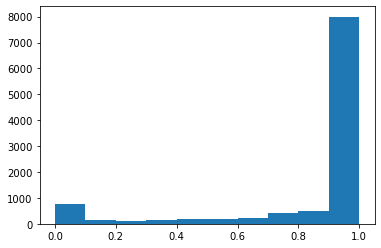

In [21]:
import matplotlib.pyplot as plt
plt.hist(pnormal_latest)

In [20]:
min(pnormal_latest)

1.0000000000000001e-11